<a href="https://colab.research.google.com/github/Mozy-Lee/code_learn/blob/master/Figure%20plot%20code%20(Draft).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter estimation for hydraulic model calibration and fault detection


### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

### Preamble
You have been tasked with the evaluation and calibration of the hydraulic model of EXNING, a district metered area (DMA) in Anglian Water's (AW) water distribution network. To achieve this, you have been provided:
* a hydraulic model of the EXNING DMA, in use by Anglian Water in early 2019 (no record of recent calibration),
* pipe groups (based on material & age) and corresponding ranges of H-W coefficients,
* hourly loading conditions (demands, reservoir heads) and head measurements covering a period of 4 days in December 2019.

The objective of the coursework is to prepare a short calibration report for AW by completing the tasks below and answering the questions (max. 100-150 words per question) based on your results. Don't forget to include titles, labels and legends in your plots, and watch for significant figures in your reporting!

You have also been provided the following information about EXNING:
* EXNING is part of a larger system of cascading DMAs: EXNING is fed by the NEWSEV DMA and feeds into the BURWEL DMA.
* According to AW's existing records, EXNING contains mostly old, cast iron pipes.
* The "reservoir" head  and total demand of EXNING are derived from flow and pressure sensors at the DMA inlet (& outlet).
* Node elevations have been updated in the provided model following a GPS survey of sensor locations.

First, we must clone the GitHub repository and install dependencies (only run this once).

In [ ]:
# run this cell once
import sys
import os

if 'google.colab' in sys.modules:
  !git clone https://github.com/bradleywjenks/CIVE_70019_70057.git
  !pip install wntr
  !pip install cvxpy
  !apt-get install libsuitesparse-dev && pip install scikit-sparse

fatal: destination path 'CIVE_70019_70057' already exists and is not an empty directory.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsuitesparse-dev is already the newest version (1:5.10.1+dfsg-4build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
# load packages
!pip install --upgrade matplotlib
import numpy as np
from numpy import linalg as la
import networkx as nx
import pandas as pd
import wntr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from datetime import datetime, timedelta
import cvxpy as cp
import warnings
warnings.filterwarnings('ignore')

# improve matplotlib image quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Load network properties and operational data

Load functions created in previous assignments.

In [ ]:
# load functions from src folder
if 'google.colab' in sys.modules:
    sys.path.append('/content/CIVE_70019_70057/src/')
    from general_functions import *
    from hydraulic_functions import *
else:
    sys.path.append('/home/bradw/workspace/CIVE_70019_70057/src/')
    from general_functions import *
    from hydraulic_functions import *

Load network .inp file and operational data from the module repository's data directory.

In [ ]:
if 'google.colab' in sys.modules:
    # if run in Google Colab
    data_dir = '/content/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/content/CIVE_70019_70057/data/networks/'
else:
    # replace with local directory
    data_dir = '/home/bradw/workspace/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/home/bradw/workspace/CIVE_70019_70057/data/networks/'

net_name = 'exning.inp'
data_name = 'exning_coursework_dataset.npy'

# load operational data
data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()
h_data = data['h_data']
sensor_idx = data['sensor_idx'] - 1 # matlab to python index offset
d_data = data['d']
h0_data = data['h0'].reshape(-1, 1).T

# load network properties
wdn = load_network_data(os.path.join(net_dir, net_name))
A12 = wdn.A12
A10 = wdn.A10
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df


Plot sensor nodes in network. We provide a plotting function below.

In [ ]:
#### DO NOT CHANGE THIS ####
# network plotting function
def plot_network(wdn, sensor_idx, vals=None, highlight_valves=None):

    # unload data
    link_df = wdn.link_df
    node_df = wdn.node_df
    net_info = wdn.net_info
    h0_df = wdn.h0_df

    # draw network
    uG = nx.from_pandas_edgelist(link_df, source='node_out', target='node_in')
    pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in node_df.iterrows()}
    nx.draw(uG, pos, node_size=20, node_shape='o')

    # draw reservoir
    nx.draw_networkx_nodes(uG, pos, nodelist=net_info['reservoir_names'], node_size=100, node_shape='s', node_color='black')

    # draw sensor nodes
    sensor_names = [net_info['junction_names'][i] for i in sensor_idx]
    nx.draw_networkx_nodes(uG, pos, sensor_names, node_size=100, node_shape='o', node_color='red', edgecolors='white')

    # reservoir labels
    reservoir_labels = {node: 'Reservoir' for node in net_info['reservoir_names']}
    labels_res = nx.draw_networkx_labels(uG, pos, reservoir_labels, font_size=12, verticalalignment='top')
    for _, label in labels_res.items():
        label.set_y(label.get_position()[1] - 1500)

    # sensor labels
    sensor_labels = {node: str(idx+1) for (idx, node) in enumerate(sensor_names)}
    labels_sen = nx.draw_networkx_labels(uG, pos, sensor_labels, font_size=12, verticalalignment='bottom')
    for _, label in labels_sen.items():
        label.set_y(label.get_position()[1] + 1000)

    # plot sensor vals
    if vals is not None:

        cmap = cm.get_cmap('RdYlGn_r')

        # plot residuals
        nx.draw_networkx_nodes(uG, pos, nodelist=sensor_names, node_size=100, node_shape='o', node_color=vals, cmap=cmap, edgecolors='white')

        # create color bar
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array(vals)
        colorbar = plt.colorbar(sm,ax=plt.gca())
        colorbar.set_label('Mean pressure residual [m]', fontsize=12)

    # highlight link
    if highlight_valves is not None:
        nx.draw_networkx_nodes(uG, pos, highlight_valves, node_size=200, node_shape='d', node_color='limegreen', edgecolors='white')

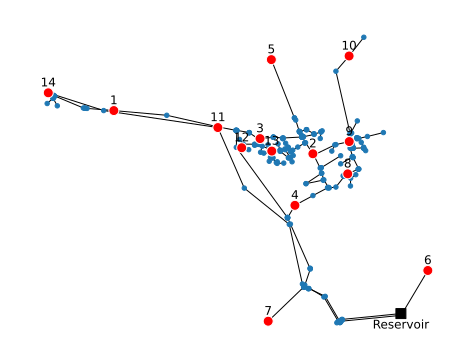

In [ ]:

plot_network(wdn,sensor_idx)

### Preliminary model evaluation

Simulate initial (uncalibrated) network hydraulics over 4 days. We first define a function to solve network hydraulics using the `wntr` package, which we used previously in the hyraulic modelling notebook. The following tasks are performed in this function:
- Load network properties
- Modify simulation time to match operational data
- Assign h0 data at model reservoir
- Scale and apply new demand pattern from inflow data
- Option to modify pipe roughness (or HW) coefficients

<font color="blue">NB: this is done for you below. Provided the correct inputs, you do not need to replicate this function.

In [ ]:
#### DO NOT CHANGE THIS ####
# hydraulic solver function
def hydraulic_solver(inp_file, d_data, h0_data, C=None, demand=False):

    # load network from wntr
    inp_file = os.path.join(net_dir, net_name)
    wn = wntr.network.WaterNetworkModel(inp_file)

    # get network properties
    reservoir_names = wn.reservoir_name_list
    junction_names = wn.junction_name_list
    link_names = wn.link_name_list

    # modify simulation time and hydraulic time step
    nt = h0_data.shape[1]
    wn.options.time.duration = (nt - 1) * 3600
    wn.options.time.hydraulic_timestep = 3600
    wn.options.time.pattern_timestep = 3600
    wn.options.time.report_timestep = 3600

    # assign reservoir data
    for (i, name) in enumerate(reservoir_names):
        wn.add_pattern(f'h0_{i}', h0_data[i])
        reservoir = wn.get_node(name)
        reservoir.head_timeseries.base_value = 1
        reservoir.head_timeseries.pattern_name = wn.get_pattern(f'h0_{i}')

    # replace demand data
    for idx, name in enumerate(junction_names):

        if any(val != 0 for val in d_data[idx, :]):
            node = wn.get_node(name)
            d_pat = d_data[idx, :]
            wn.add_pattern('d_'+name, d_pat)

            for (i, num) in enumerate(node.demand_timeseries_list):
                if i == 0:
                    node.demand_timeseries_list[i].base_value = 1
                    node.demand_timeseries_list[i].pattern_name = 'd_'+name
                else:
                    node.demand_timeseries_list[i].base_value = None
                    node.demand_timeseries_list[i].pattern_name = None

    # assign roughness (or HW) coefficients
    if C is not None:
        for name, link in wn.links():

            # check if the link is a pipe
            if isinstance(link, wntr.network.Pipe):
                link.roughness = C[link_names.index(name)]

            # check if link is a valve
            elif isinstance(link, wntr.network.Valve):
                link.minor_loss = C[link_names.index(name)]
                link.initial_setting = C[link_names.index(name)]

    # run simulation and get results
    sim = wntr.sim.EpanetSimulator(wn)
    results = sim.run_sim()

    q_sim = results.link['flowrate'].T
    h_sim = results.node['head'].T
    h_sim = h_sim[~h_sim.index.isin(reservoir_names)] # delete reservoir nodes
    d = results.node['demand'].T
    d = d[~d.index.isin(reservoir_names)] # delete reservoir nodes


    if demand == True:
        return d.to_numpy()
    else:
        return q_sim.to_numpy(), h_sim.to_numpy()

Run simulation with initial $C_0$ values.

In [ ]:
C_0 = link_df['C'].to_numpy()
_, h_0 = hydraulic_solver(os.path.join(net_dir,net_name),d_data,h0_data,C=C_0)

Compare simulated heads at sensor nodes (node indices in `sensor_idx`) with the simulated heads over the 4-day period. Visualise the results with, e.g. a boxplot of pressure residuals on the test dataset.

Text(0, 0.5, 'Pressure residual [m]')

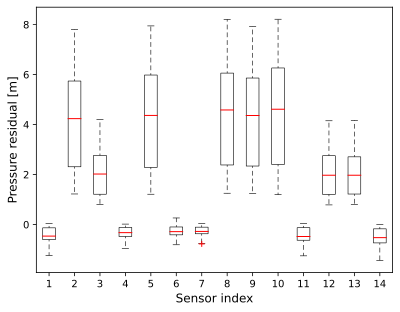

In [ ]:
# compute pressure residuals
residuals_0 = h_0[sensor_idx,:] - h_data

# create figure and axis for box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_0.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual [m]', fontsize=12)

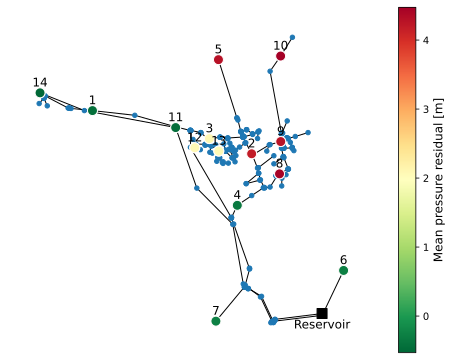

In [ ]:
# spatial residuals plot
mean_residuals_0 = np.mean(residuals_0,axis = 1)
plot_network(wdn,sensor_idx,vals = mean_residuals_0)

Text(0, 0.5, 'Pressure residual [m]')

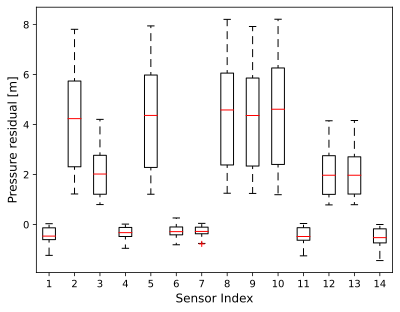

In [ ]:
# compute all the pressure residuals
residuals_0_all = h_0[sensor_idx,:] - h_data

# create figure and axis for box plots
fig,ax = plt.subplots()
boxplot = ax.boxplot(residuals_0_all[0:].T, medianprops=dict(color="red"),flierprops=dict(marker="+",markeredgecolor="red"),whiskerprops=dict(linestyle=(5,(8,5))),boxprops=dict(color='black'))
ax.set_xlabel('Sensor Index',fontsize=12)
ax.set_ylabel('Pressure residual [m]',fontsize = 12)


Text(0, 0.5, 'Residual in Sensor 10')

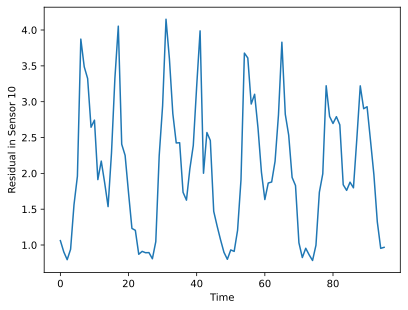

In [ ]:
plt.plot(residuals_0_all[11])
plt.xlabel('Time')
plt.ylabel('Residual in Sensor 10')

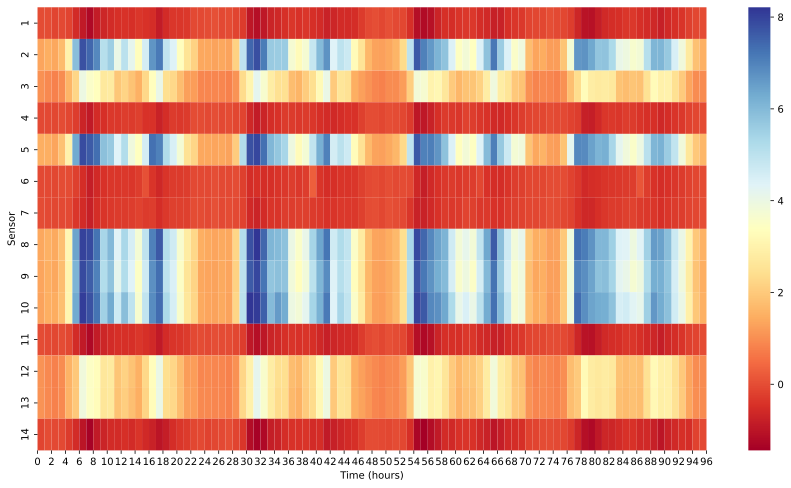

In [ ]:
import seaborn as sns
# 这里我们用随机数据生成一个示例数据集
data = residuals_0_all

# 设置热力图的尺寸
plt.figure(figsize=(15, 8))

# 使用 seaborn 绘制热力图
sns.heatmap(data, cmap="RdYlBu", cbar=True)

# 设置坐标轴标签
plt.xlabel('Time (hours)')
plt.ylabel('Sensor')

# 设置 x 轴的刻度
plt.xticks(ticks=np.arange(0, 97, 2), labels=np.arange(0, 97, 2))

# 设置 y 轴的刻度
plt.yticks(ticks=np.arange(0.5, 14.5, 1), labels=np.arange(1, 15, 1))

# 显示热力图
plt.show()

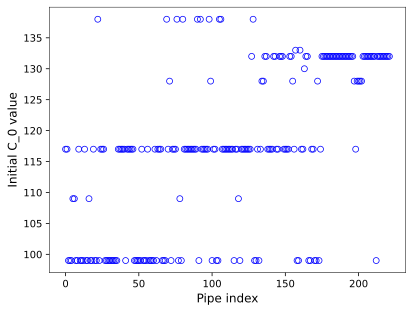

In [ ]:
# C_0 value scatter plot(pipes only)
pipe_C =[C_0[idx] for idx, row in link_df.iterrows() if row ['link_type']=='pipe']
fig,ax = plt.subplots()
ax.scatter(range(len(pipe_C)),pipe_C,facecolors='none',edgecolors='b',linewidth=0.75)
ax.set_xlabel('Pipe index',fontsize = 12)
ax.set_ylabel('Initial C_0 value',fontsize=12)
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(0.5)

**<u>Question 1:</u>** Is the current hydraulic model of EXNING accurate according to hydraulic model calibration guidelines? Comment on the results of the preliminary model evaluation and, in particular, on
* the **sign** (i.e. are heads over or underestimated in the hydraulic simulation?) of pressure/head residuals,
* the **temporal** distribution (i.e. are the residuals time/flow dependent?) of pressure/head residuals,
* and the **spatial** distribution (i.e. are all sensors affected?) of the pressure/head residuals.

Given the information you were provided about the EXNING system and the results of the preliminary model evaluation, identify the most likely sources of model errors.


<font color="red">Enter response here...:  
<font color="green">the current hydraulic model of EXNING accurate is not according to the guidelines.  
(1)More than half heads overestimated  
(2)The residuals are also time-dependent as shown in the ‘Pressure residuals over time’ graph. The errors are larger when there is a peak in demand  
(3)Not all sensors affected  
  
<font color="green">Model error sources: H-W coefficient related


### Part 1: parameter estimation without pipe grouping + valves fixed

Based on the outcome of the initial comparison between measured and simulated heads at sensor nodes, you are tasked with the calibration of the hydraulic model of EXNING. Given the information provided by Anglian Water about the EXNING system, the first step is to adjust the pipe roughness (H-W) coefficients. In order to limit the number of parameters in question, and regardless of your answer to question 1, you will first assume (in Parts 1 and 2 of the coursework) that the status of valves is known and minor/local loss coefficients are fixed to C=0.2 (fully open).

First, you will investigate the effect of pipe grouping on the calibration of H-W coefficients. In Part 1, you will solve the model calibration problem without pipe grouping. Complete the code below to calibrate the network model using the head measurements loaded previously.

#### Separate the data into train and test datasets
We suggest you use the first day worth of data (loading conditions + $h_0$ measurements) as a train dataset, and the remaining three (3) days as a test dataset.

In [ ]:
# tain data
nt_train = 24
data_train = {
    'd': d_data[:, :nt_train],
    'h0': h0_data[:, :nt_train],
    'h_data': h_data[:, :nt_train]
}

# test data
data_test = {
    'd': d_data[:, nt_train:],
    'h0': h0_data[:, nt_train:],
    'h_data': h_data[:, nt_train:]
}

**<u>Question 2:</u>** Briefly comment on the definition of the train dataset. What impact may it have on the predictive ability of your model? (i.e. what range of conditions will you confidently be able to use your model for?)

<font color="red">Enter response here...  
<font color="green">The first day of data is used as a train data set for model fitting. The model can be confidently used on conditions with similar demand stable operating conditions and minimal anomalies occurring.  
However, it won’t be able to represent a wide range of loading conditions. For example, this would be the case of varying demand because of external conditions like a change of seasons. Moreover, it will not be able to
predict system shutdowns and anomalies like leaks. Therefore, there is a risk of overfitting.

#### Definition of the loss function
The calibration of H-W coefficients is a model fitting/parameter estimation problem. In particular, for the hydraulic model calibration problem, the loss function is defined as the mean squared error (MSE) between simulated and measured heads at sensor locations:

In [ ]:
def loss_fun(h, h_data):
    return ( 1/len(h_data.flatten()) ) * np.sum( ( h[sensor_idx,:] - h_data )**2 )

Compute MSE for `C_0` values and using the training data.

In [ ]:
h_0 = h_0[:, :nt_train]
mse_0 = loss_fun(h_0,data_train['h_data'])
mse_0

9.705414431633923

**<u>Question 3:</u>**  Justify the choice/definition of `loss_fun`.

<font color="red">Enter response here...  
<font color="green">The loss function calculates the MSE between simulated and measured heads. This choice can be justified by
the fact that calculating the squares of the errors allows us to accentuate large errors compared to small ones.
This makes recognising anomalies easier. Using this function also allows for a more accurate model since large
errors are usually linked to incorrect estimates of HW coefficients. Moreover, the MSE function is convex which
makes Sequential Convex Programming applicable.

#### Solve the parameter estimation problem using the train dataset

The following function is needed for the sequential convex programming (SCP) method used in this coursework. <font color="blue">As with the `hydraulic_solver` function, we provide the following code in `linear_approx_calibration` for you to use throughout this notebook.

In [ ]:
#### DO NOT CHANGE THIS ####
# compute matrices for the head loss linear approximation of the HW headloss
def linear_approx_calibration(wdn, q, C):
    # unload data
    A12 = wdn.A12
    A10 = wdn.A10
    net_info = wdn.net_info
    link_df = wdn.link_df

    K = np.zeros((net_info['np'], 1))
    n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)
    b1_k = copy.copy(K)
    b2_k = copy.copy(K)

    for idx, row in link_df.iterrows():
        if row['link_type'] == 'pipe':
            K[idx] = 10.67 * row['length'] * (C[idx] ** -row['n_exp']) * (row['diameter'] ** -4.8704)
            b1_k[idx] = copy.copy(K[idx])
            b2_k[idx] = (-n_exp[idx] * K[idx]) / C[idx]

        elif row['link_type'] == 'valve':
            K[idx] = (8 / (np.pi ** 2 * 9.81)) * (row['diameter'] ** -4) * C[idx]
            b1_k[idx] = -n_exp[idx] * copy.copy(K[idx])
            b2_k[idx] = copy.copy(K[idx]) / C[idx]

    a11_k = np.tile(K, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b1_k = np.tile(b1_k, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b2_k = np.tile(b2_k, q.shape[1]) * np.abs(q) ** (n_exp - 1) * q

    return a11_k, b1_k, b2_k

Solve the model calibration problem without pipe grouping using the `cvxpy` modelling interface. (Use the code provided previously.)

In [ ]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define SCP problem parameters
Ki = np.inf
iter_max = 50
delta_k = 20
C_up_pipe = 200
C_lo_pipe = 1e-4

# initialise values
theta_k = C_0
q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_k)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
objval_k = loss_fun(h_k, h_data)

### main scp code ###
for k in range(iter_max):
     # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    objective = cp.Minimize(loss)

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]

    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]

    # variable bounds
    lower_bound_pipe = [theta[idx] >= C_lo_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
    constraints += lower_bound_pipe
    upper_bound_pipe = [theta[idx] <= C_up_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
    constraints += upper_bound_pipe

    # valve minor loss coefficient constraints
    valve_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += valve_constraints

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False, abstol=1e-3)

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
    objval_tilde = loss_fun(h_tilde, h_data)

    predicted_decrease = objval_k - cvx_val
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

Iteration 0 successful! Update estimate and increase trust region size. 

0 4.650719520865095 0.5208118567604394 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 1.6535174252474512 0.6444598695257642 24.200000000000003 

Iteration 2 unsuccessful! Return to previous estimate and reduce trust region size. 

2 1.6535174252474512 0.6444598695257642 6.050000000000001 

Iteration 3 successful! Update estimate and increase trust region size. 

3 1.1967449914751231 0.27624289094139504 6.655000000000001 

Iteration 4 successful! Update estimate and increase trust region size. 

4 0.781420764861514 0.347044883890991 7.320500000000002 

Iteration 5 successful! Update estimate and increase trust region size. 

5 0.41792177243473777 0.4651770323651391 8.052550000000002 

Iteration 6 successful! Update estimate and increase trust region size. 

6 0.2533967294553857 0.39367425635869235 8.857805000000003 

Iteration 7 successful! Update estimate and increase trust reg

**<u>Question 4:</u>** Describe the nature/role of the different outputs of the SCP algorithm printed above (objvalk, Ki, Deltak) and explain their trends.

<font color="red">Enter response here...  
<font color="green">• Objvalk represents the MSE between measured and simulated heads. At each iteration, its value
decreases because the model is more accurate.  
• Ki is the reduction factor between two successful iterations. It calculates the absolute difference of
objvalk compared to its value at the previous iteration. This evaluates the convergence of the model.
Overall, it decreases as we get closer to the solution.  
• Deltak represents the trust region of the algorithm. When the actual reduction is sufficiently large
compared to the expected reduction, the iteration is successful and trust region is increased. Otherwise,
Deltak is reduced.

Store the solution (i.e. new coefficients `theta_k`) as $C_1$.

In [ ]:
C_1 = theta_k

# compute train mse
mse_train_1 = loss_fun(h_k, data_train['h_data'])
mse_train_1

0.13983107555009858

#### Evaluate test model error
Compute the MSE and plot the pressure residuals corresponding to the test dataset.

In [ ]:
# compute hydraulics
_, h_test = hydraulic_solver(os.path.join(net_dir, net_name), data_test['d'], data_test['h0'], C=C_1)

# compute test mse
mse_test_1 = loss_fun(h_test, data_test['h_data'])
mse_test_1

0.14406340984502547

Text(0, 0.5, 'Pressure residual [m]')

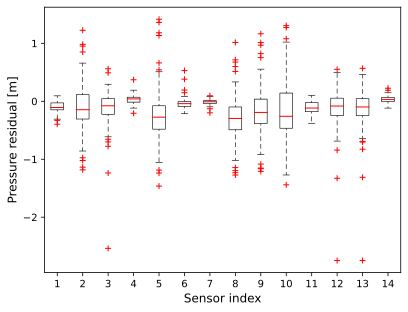

In [ ]:
# compute pressure residuals
residuals_1 = h_test[sensor_idx,:] - data_test['h_data']

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_1.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual [m]', fontsize=12)

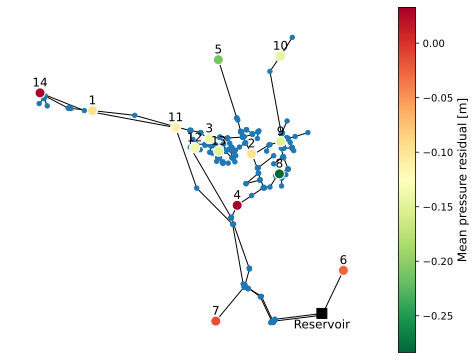

In [ ]:
# spatial residuals plot
mean_residuals_1 = np.mean(residuals_1, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_1)

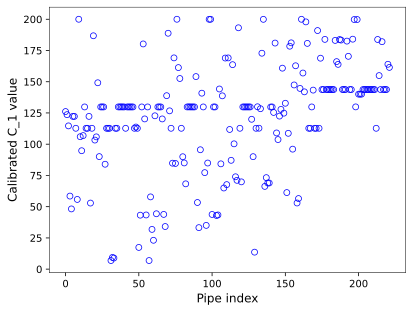

In [ ]:
# C_1 value scatter plot (pipes only)
pipe_C = [C_1[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=12)
ax.set_ylabel('Calibrated C_1 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

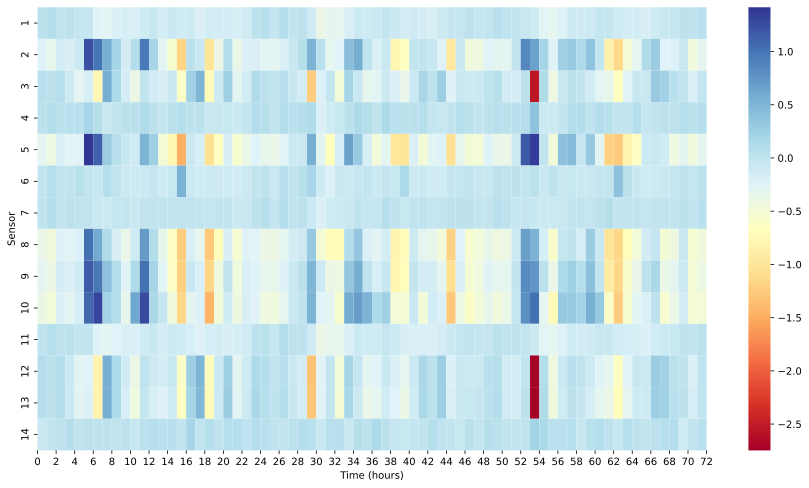

In [ ]:
import seaborn as sns
# 这里我们用随机数据生成一个示例数据集
data = residuals_1

# 设置热力图的尺寸
plt.figure(figsize=(15, 8))

# 使用 seaborn 绘制热力图
sns.heatmap(data, cmap="RdYlBu", cbar=True)

# 设置坐标轴标签
plt.xlabel('Time (hours)')
plt.ylabel('Sensor')

# 设置 x 轴的刻度
plt.xticks(ticks=np.arange(0, 73, 2), labels=np.arange(0, 73, 2))

# 设置 y 轴的刻度
plt.yticks(ticks=np.arange(0.5, 14.5, 1), labels=np.arange(1, 15, 1))

# 显示热力图
plt.show()

**<u>Question 5:</u>** Comment on the improvement in model accuracy (before vs. after calibration).

<font color="red">Enter response here...  
<font color="green">Before calibration, many sensors were presenting anomalies.  
After calibration, all the sensors are well within range (+- 2.0 m pressure residuals). The medians are around zero compared to the previous part, which shows that simulated heads are closer to the measured ones.  
Moreover, the MSE changed from approximately 9.7 to 0.14. There are some considerable outliers (for example sensor 3, 12, 13 with points at -2.5 m), but the results generally improved. By looking at this we could consider the model calibrated.

#### Discuss the values of the calibrated H-W coefficients $C_1$
Visualise the values of newly calibrated coefficients $C_1$ compared to original model coefficients $C_0$.

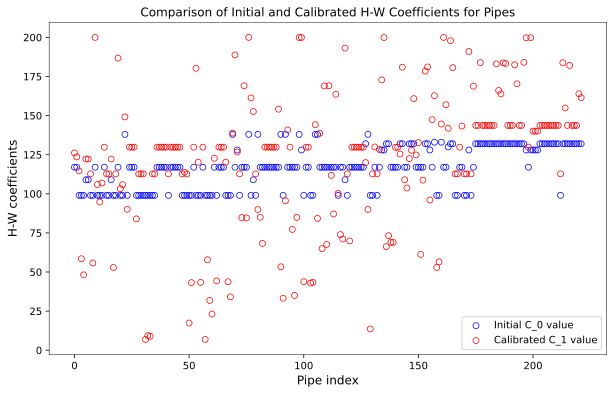

In [ ]:

# 计算管道的 C_0 和 C_1 值
pipe_C0 = [C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
pipe_C1 = [C_1[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']

# 绘制散点图进行对比
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制 C_0 值的散点图
ax.scatter(range(len(pipe_C0)), pipe_C0, facecolors='none', edgecolors='b', linewidth=0.75, label='Initial C_0 value')

# 绘制 C_1 值的散点图
ax.scatter(range(len(pipe_C1)), pipe_C1, facecolors='none', edgecolors='r', linewidth=0.75, label='Calibrated C_1 value')

# 设置坐标轴标签和标题
ax.set_xlabel('Pipe index', fontsize=12)
ax.set_ylabel('H-W coefficients', fontsize=12)
ax.set_title('Comparison of Initial and Calibrated H-W Coefficients for Pipes')

# 设置图例
ax.legend()

# 设置坐标轴的线条宽度
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)

# 显示图形
plt.show()

**<u>Question 6:</u>** Comment on the values of parameter estimates in $C_1$ and explain the results of the calibration without pipe grouping. Can the new model be considered calibrated?

<font color="red">Enter response here...  
<font color="green">C1 values are much more scattered compared to the initial values plotted in the preliminary part.  
Initially,Anglian water probably assumed that pipes would have the same HW coefficients based on their material and age. However, the calibration shows a wide spread of values (0 to 200). The model without pipe grouping tries
to determine HW coefficients for each pipe.  
With the lack of individual pipe measurements, we get a variation of possible results. The model is probably overfitting and cannot be considered calibrated because it is unrealistic.
Therefore, we would have to modify the formulation of the problem by considering pipe groups.

### Part 2: parameter estimation with pipe grouping + valves fixed
In order to reduce the underdeterminedness of the model calibration problem (and improve the quality of estimated H-W coefficients), pipes can be grouped based on their material and age. In particular, all pipes of a group are assumed to share the same H-W coefficient. This also allows tighter bounds on the grouped coefficient estimates (stored in $\Theta_{\text{lb}}$ and $\Theta_{\text{ub}}$, for lower and upper bounds, respectively) in the formulation of the parameter estimation problem. Here, you will still assume the status of valves is known with minor/local loss coefficients fixed to C=0.2. Use the code provided in Week 5 and modify as necessary below to calibrate the hydraulic model with pipe grouping, using the same train data as before. (Note that Part 2 might take a little longer to run than Part 1.)

Load pipe grouping information.

In [ ]:

data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()
link_groups = data['G'][0] - 1 # matlab to python index offset
ng = link_groups.shape[0]
thetaG_lo = data['thetaG_min'][:, 0]
thetaG_up = data['thetaG_max'][:, 0]

In [ ]:
df = pd.DataFrame({
    'thetaG_lo': thetaG_lo,
    'thetaG_up': thetaG_up
})


df.index = range(1, 9)
df

,thetaG_lo,thetaG_up
1,107,132
2,108,133
3,113,138
4,92,117
5,105,130
6,103,128
7,84,109
8,74,99


#### Solve the parameter estimation problem using the train dataset
Solve the model calibration problem with pipe grouping. (Use the code provided previously and modify as necessary.)

In [ ]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define problem parameters
Ki = np.inf
iter_max = 50
delta_k = 20
C_up_pipe = 200
C_lo_pipe = 0

convergence_iterations = np.zeros(iter_max)
convergence_loss = np.zeros(iter_max)
# initialise values
theta_k = C_0
q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_k)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
objval_k = loss_fun(h_k, h_data)

### main scp code ###
for k in range(iter_max):
     # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])
    theta2 = cp.Variable(8)

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    objective = cp.Minimize(loss)

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]
    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]

    for group_id, indices in enumerate(link_groups):
      lo_bound = thetaG_lo[group_id]
      up_bound = thetaG_up[group_id]
      for idx in indices:
        constraints.append(theta[idx] >= lo_bound)
        constraints.append(theta[idx] <= up_bound)

    for j in range(8):
      for i in link_groups[j]:
        constraints.append(theta2[j] == theta[i])

    # 添加 Theta2 的上下限约束
    constraints += [thetaG_lo <= theta2]
    constraints += [theta2 <= thetaG_up]

    # valve minor loss coefficient constraints
    valve_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += valve_constraints

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False, abstol=1e-3)

    # store optimal solution and compute actual and predicted decrease in objval
    theta = theta.value
    [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta)
    objval_tilde = loss_fun(h_tilde, h_data)

    predicted_decrease = objval_k - cvx_val
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

Iteration 0 successful! Update estimate and increase trust region size. 

0 4.743010733864835 0.5113026066763909 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 3.7300708066642994 0.2135647553922238 24.200000000000003 

Iteration 2 unsuccessful! Return to previous estimate and reduce trust region size. 

2 3.7300708066642994 0.2135647553922238 6.050000000000001 

Iteration 3 unsuccessful! Return to previous estimate and reduce trust region size. 

3 3.7300708066642994 0.2135647553922238 1.5125000000000002 

Iteration 4 unsuccessful! Return to previous estimate and reduce trust region size. 

4 3.7300708066642994 0.2135647553922238 0.37812500000000004 

Iteration 5 unsuccessful! Return to previous estimate and reduce trust region size. 

5 3.7300708066642994 0.2135647553922238 0.09453125000000001 



Store the solution (i.e. new coefficients `theta_k`) as $C_2$.

In [ ]:
C_2 = theta_k

# compute train mse
mse_train_2 = loss_fun(h_k, data_train['h_data'])
mse_train_2

3.7300708066642994

#### Evaluate test model error
Compute the MSE and plot the pressure residuals corresponding to the test dataset.

In [ ]:
# compute hydraulics
_, h_test = hydraulic_solver(os.path.join(net_dir, net_name), data_test['d'], data_test['h0'], C=C_2)

# compute test mse
mse_test_2 = loss_fun(h_test, data_test['h_data'])
mse_test_2

3.51532030004397

In [ ]:
# compute pressure residuals
residuals_2 = h_test[sensor_idx,:] - data_test['h_data']

**<u>Question 7:</u>** Comment on the improvement in model accuracy after calibration with pipe grouping.

<font color="red">Enter response here...  
<font color="green">Even though there are still anomalies for the sensors discussed in question 1, these residuals were reduced and there are also much fewer outliers compared to part 1 without the pipe grouping. The model is therefore more robust.  
Moreover, the pressure residuals are evenly distributed between positive and negative values. Therefore, the model is not exclusively overpredicting pressure heads like it was in question 1.  
However, the increase of MSE (around 3.5) and the presence of anomalies suggest that we still need to recalibrate the model by adjusting valve minor/local loss coefficients.

#### Discuss the values of the calibrated H-W coefficients $C_2$
Visualise the values of newly calibrated coefficients $C_2$ compared to model coefficients $C_1$ and $C_0$.

Text(0, 0.5, 'Pressure residual [m]')

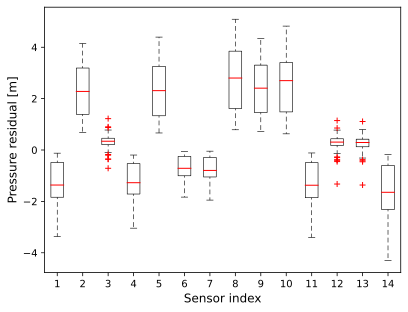

In [ ]:
# generate C_2 value scatter plot (pipes only)
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_2.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual [m]', fontsize=12)

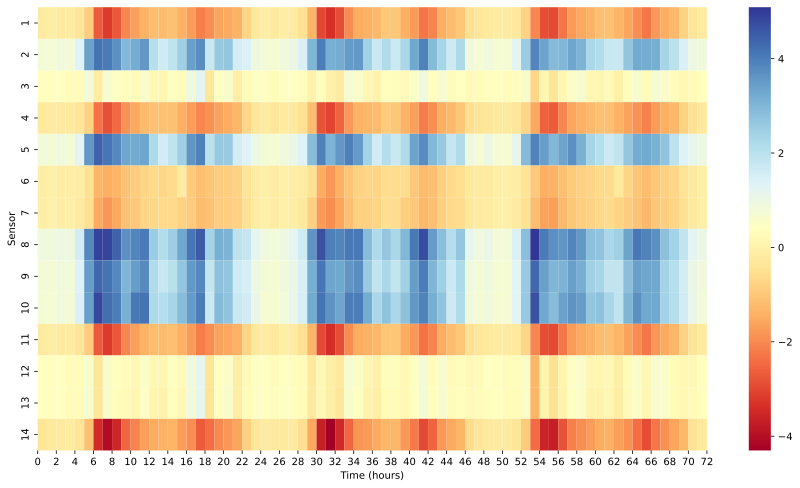

In [ ]:
import seaborn as sns
# 这里我们用随机数据生成一个示例数据集
data = residuals_2

# 设置热力图的尺寸
plt.figure(figsize=(15, 8))

# 使用 seaborn 绘制热力图
sns.heatmap(data, cmap="RdYlBu", cbar=True)

# 设置坐标轴标签
plt.xlabel('Time (hours)')
plt.ylabel('Sensor')

# 设置 x 轴的刻度
plt.xticks(ticks=np.arange(0, 73, 2), labels=np.arange(0, 73, 2))

# 设置 y 轴的刻度
plt.yticks(ticks=np.arange(0.5, 14.5, 1), labels=np.arange(1, 15, 1))

# 显示热力图
plt.show()

**<u>Question 8:</u>** Comment on the values of the H-W coefficient estimates $C_2$ and justify the results of the calibration with pipe grouping.

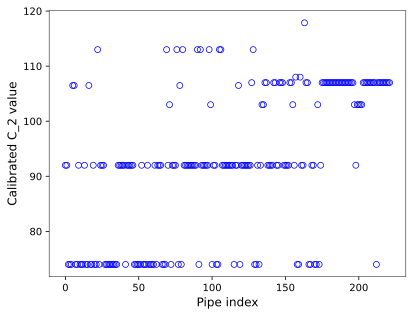

In [ ]:
# C_2 value scatter plot (pipes only)
pipe_C = [C_2[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=12)
ax.set_ylabel('Calibrated C_2 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

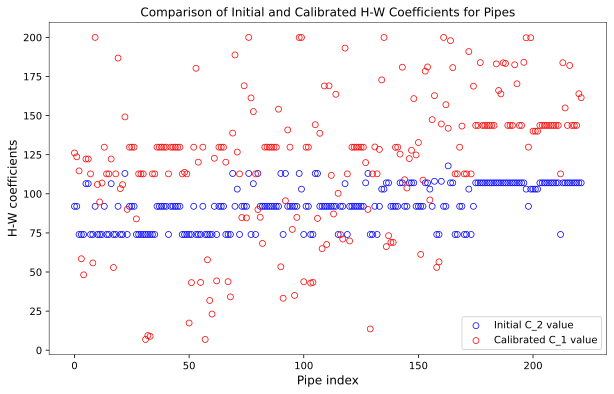

In [ ]:
# 计算管道的 C_2 和 C_1 值
pipe_C2 = [C_2[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
pipe_C1 = [C_1[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']

# 绘制散点图进行对比
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制 C_2 值的散点图
ax.scatter(range(len(pipe_C2)), pipe_C2, facecolors='none', edgecolors='b', linewidth=0.75, label='Initial C_2 value')

# 绘制 C_1 值的散点图
ax.scatter(range(len(pipe_C1)), pipe_C1, facecolors='none', edgecolors='r', linewidth=0.75, label='Calibrated C_1 value')

# 设置坐标轴标签和标题
ax.set_xlabel('Pipe index', fontsize=12)
ax.set_ylabel('H-W coefficients', fontsize=12)
ax.set_title('Comparison of Initial and Calibrated H-W Coefficients for Pipes')

# 设置图例
ax.legend()

# 设置坐标轴的线条宽度
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)

# 显示图形
plt.show()

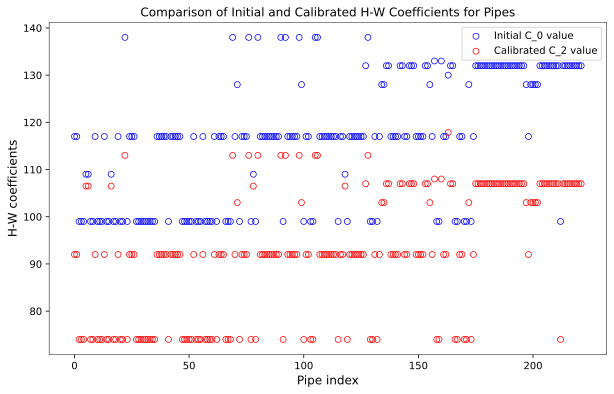

In [ ]:
# 计算管道的 C_0 和 C_2 值
pipe_C0 = [C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
pipe_C2 = [C_2[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']

# 绘制散点图进行对比
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制 C_0 值的散点图
ax.scatter(range(len(pipe_C0)), pipe_C0, facecolors='none', edgecolors='b', linewidth=0.75, label='Initial C_0 value')

# 绘制 C_2 值的散点图
ax.scatter(range(len(pipe_C2)), pipe_C2, facecolors='none', edgecolors='r', linewidth=0.75, label='Calibrated C_2 value')

# 设置坐标轴标签和标题
ax.set_xlabel('Pipe index', fontsize=12)
ax.set_ylabel('H-W coefficients', fontsize=12)
ax.set_title('Comparison of Initial and Calibrated H-W Coefficients for Pipes')

# 设置图例
ax.legend()

# 设置坐标轴的线条宽度
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)

# 显示图形
plt.show()

<font color="red">Enter response here...  
<font color="green">The results from C2 are much more realistic compared to C1(which were ranging from 0 to 200). The values are consistent and between 70-120. This coincides with the range of HW coefficients for old cast iron pipes.
This model is therefore more reliable for the network compared to the previous one that was overfitting.  
This can be explained by the fact that C1 did not consider pipes having the same HW coefficients based on their age
and materials.

**<u>Question 9:</u>** Can the newly calibrated model (with H-W coefficients in $C_2$) be considered calibrated? Considering the results of Part 2, as well as your answer to question 1, provide an interpretation of the remaining pressure/head residuals.

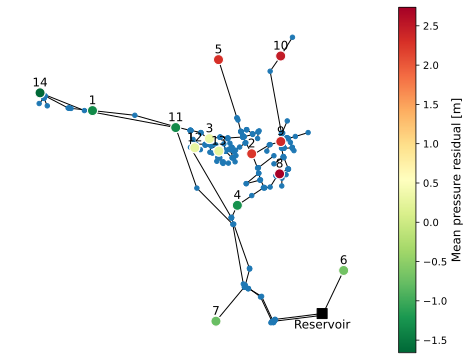

In [ ]:
# spatial residuals plot (hint: you can use `plot_network` function`)
mean_residuals_2 = np.mean(residuals_2, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_2)

<font color="red">Enter response here...  
<font color="green">Even if this new model is realistic, it cannot beconsidered calibrated because it does not respect hydraulic model calibration guidelines.   
There are still anomalies exceeding the condition of 95% of all residuals to be
within +- 2.0m. In the previous part, C1 showed a wide range of values, but the pressure residuals were all within range. The remaining pressure residuals in part 2 can be explained by the fact that we assumed fixed
minor loss coefficiens.  
This suggests that we still need to recalibrate the model by allowing valve minor/local loss coefficients to vary.

### Part 3: parameter estimation with pipe grouping + valve coefficients free

Following initial reports concerning discrepancies in the EXNING model, AW were able to confirm that:
* flow and head sensors had been calibrated before collection of load/field data corresponding to the train and test datasets,
* allocation of demands in the train and test dataset is representative of normal network conditions and based on recent demand monitoring campaigns (incl. of large industrial users), and
* boundary valves (isolating EXNING from adjacent DMAs) are closed.

As a result, the remaining deviations between measured and simulated pressures must result from unknown/unreported changes in system connectivity. Errors associated with unknown valve status (e.g. closed valves) can be identified by solving a similar parameter estimation problem where valve coefficients, in addition to H-W coefficients, are free to vary.

In Part 3, you are encouraged to propose and investigate an approach to calibrate the hydraulic model with unknown valve coefficients. You may follow the suggested steps below, or come up with your own. Marks will be allocated based on the justification of the adopted approach (show your thinking!) and discussion of the obtained results in question 10, whether they lead to a firm conclusion about the existence/location of unknowingly closed valves or not.

Suggested approach:
1. Try modifying the CVXPY implementation in Part 2 to allow valve coefficients to vary. Solve the resulting parameter estimation problem and interpret the optimal value of $C_3$.
2. Next, try further modifying your CVXPY implementation to account for the expected sparsity of large valve coefficients (hint: you might want to consider regularising your problem formulation). Solve the resulting problem and comment on the optimal value of $C_3$.
3. Finally, compare the results of Part 3 with your answer to question 1 and preliminary model evaluation. Explain whether they contradict or corroborate your previous conclusions about the most likely sources of error in the EXNING model by answering question 10 below.

In [ ]:
# insert Part 3 code here...
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define problem parameters
Ki = np.inf
iter_max = 50
delta_k = 20
C_up_pipe = 200
C_lo_pipe = 0

convergence_iterations = np.zeros(iter_max)
convergence_loss = np.zeros(iter_max)
# initialise values
theta_k = C_0
q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_k)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
objval_k = loss_fun(h_k, h_data)

### main scp code ###
for k in range(iter_max):
     # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])
    theta2 = cp.Variable(8)
    num_valves = len(link_df[link_df['link_type'] == 'valve'])
    val = cp.Variable(num_valves)
    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    objective = cp.Minimize(loss)

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]
    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]
    # with group constraints
    for group_id, indices in enumerate(link_groups):
      lo_bound = thetaG_lo[group_id]
      up_bound = thetaG_up[group_id]
      for idx in indices:
        constraints.append(theta[idx] >= lo_bound)
        constraints.append(theta[idx] <= up_bound)

    for j in range(8):
      for i in link_groups[j]:
        constraints.append(theta2[j] == theta[i])

    # 添加 Theta2 的上下限约束
    constraints += [thetaG_lo <= theta2]
    constraints += [theta2 <= thetaG_up]

    # valve minor loss coefficient constraints
    valve_indices = [idx for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    valve_constraints = [theta[idx] == val[j] for j, idx in enumerate(valve_indices)]
    constraints += valve_constraints
    constraints += [val[:] >= 0]
    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False, abstol=1e-3)

    # store optimal solution and compute actual and predicted decrease in objval
    theta = theta.value
    [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta)
    objval_tilde = loss_fun(h_tilde, h_data)

    predicted_decrease = objval_k - cvx_val
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

Iteration 0 successful! Update estimate and increase trust region size. 

0 2.6643396279063807 0.7254790460856358 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 1.6855082885697539 0.3673823446096418 24.200000000000003 

Iteration 2 successful! Update estimate and increase trust region size. 

2 1.378386470101169 0.1822131760201515 26.620000000000005 

Iteration 3 successful! Update estimate and increase trust region size. 

3 1.1936093847336302 0.13405317693953914 29.282000000000007 

Iteration 4 successful! Update estimate and increase trust region size. 

4 1.0312051314977446 0.13606147481165143 32.21020000000001 

Iteration 5 successful! Update estimate and increase trust region size. 

5 0.8753762091893545 0.15111340852431637 35.43122000000001 

Iteration 6 successful! Update estimate and increase trust region size. 

6 0.7265125999577685 0.17005672266263866 38.974342000000014 

Iteration 7 successful! Update estimate and increase trust region si

In [ ]:
print(val.value)


[1.955e-06 2.375e+01 3.395e-07 4.555e-06 2.382e+01 6.883e-05 6.876e-05 5.682e+01 2.335e-05 1.299e+03 2.265e-05 3.557e-06 2.021e+02 3.805e+01 3.823e+01 8.646e-03 5.686e+01 9.704e-06 9.704e-06 3.422e-06 2.335e-05 6.094e-06 6.093e-06 4.368e-05 6.157e+00 5.178e+02 5.178e+02 8.884e+00 5.686e+01
 5.686e+01 9.783e+02 5.033e+01 5.738e+02 5.738e+02 8.559e+02 9.241e+02 9.241e+02 2.055e-03 5.686e+01 8.640e+02 1.135e+03 5.686e+01 5.686e+01 5.686e+01 5.686e+01 5.686e+01 5.686e+01 6.429e+02 5.479e+02 5.686e+01 1.122e-03 3.323e-04 3.442e+02 1.590e-01 5.686e+01 8.381e+01 2.425e+01 2.523e+01
 9.563e-04 3.628e-05 5.686e+01 4.194e+02 5.686e+01 5.686e+01 5.686e+01 5.681e+01 5.686e+01 5.674e+01 5.686e+01 5.686e+01 5.686e+01 1.156e+03 5.686e+01 4.038e+01 5.683e+01 5.686e+01 5.685e+01]


In [ ]:
C_3 = theta_k

# compute train mse
mse_train_3 = loss_fun(h_k, data_train['h_data'])
mse_train_3

# compute hydraulics
_, h_test = hydraulic_solver(os.path.join(net_dir, net_name), data_test['d'], data_test['h0'], C=C_3)

# compute test mse
mse_test_3 = loss_fun(h_test, data_test['h_data'])
mse_test_3

# compute pressure residuals
residuals_3 = h_test[sensor_idx,:] - data_test['h_data']

Text(0, 0.5, 'Pressure residual [m]')

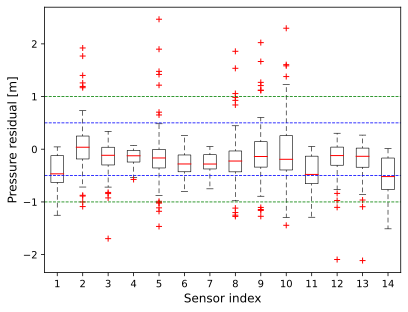

In [ ]:
# generate C_3 value scatter plot (pipes only)
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_3.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.axhline(y=0.5, color='blue', linestyle='--', linewidth=0.8)
ax.axhline(y=1.0, color='green', linestyle='--', linewidth=0.8)
ax.axhline(y=-0.5, color='blue', linestyle='--', linewidth=0.8)
ax.axhline(y=-1.0, color='green', linestyle='--', linewidth=0.8)
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual [m]', fontsize=12)

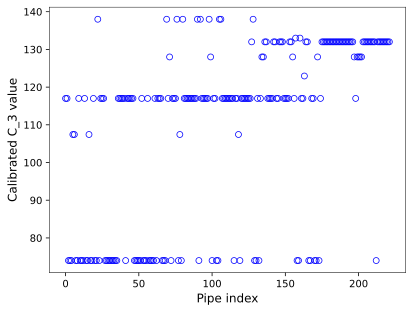

In [ ]:

# C_3 value scatter plot (pipes only)
pipe_C = [C_3[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=12)
ax.set_ylabel('Calibrated C_3 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)



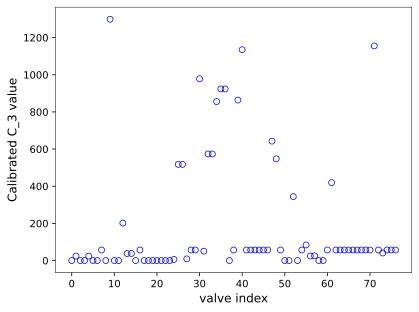

In [ ]:
# C_3 value scatter plot (pipes only)
valve_C3 = [C_3[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(range(len(valve_C3)), valve_C3, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('valve index', fontsize=12)
ax.set_ylabel('Calibrated C_3 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

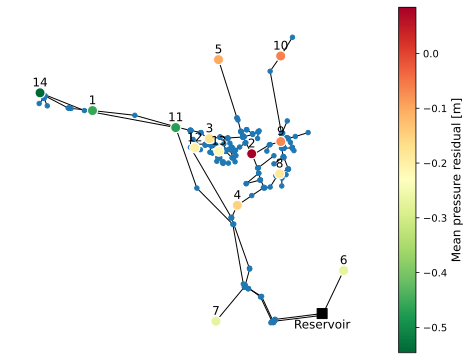

In [ ]:
# spatial residuals plot (hint: you can use `plot_network` function`)
mean_residuals_3 = np.mean(residuals_3, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_3)

**<u>Question 10:</u>** Summarise your findings and provide recommendations to AW to validate your proposed hydraulic model update. Provide plots to support your recommendations.

<font color="red">Enter response here...

In [ ]:
mse_test_3

0.2665976699249153

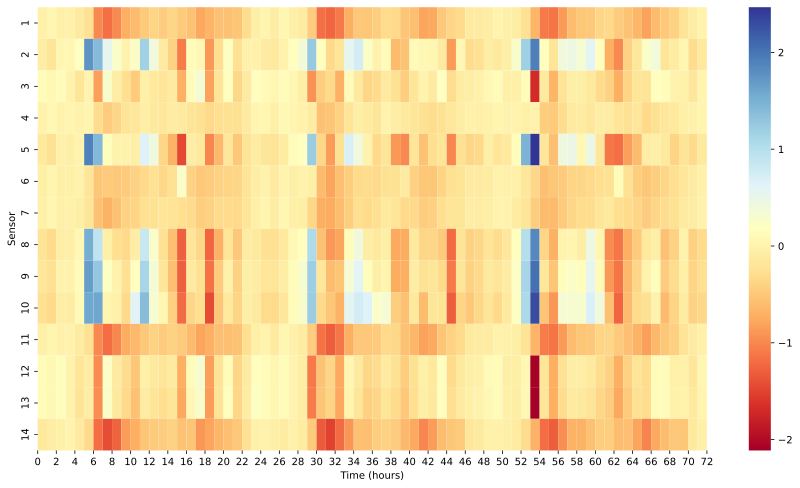

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



data = residuals_3

plt.figure(figsize=(15, 8))

sns.heatmap(data, cmap="RdYlBu", cbar=True)

plt.xlabel('Time (hours)')
plt.ylabel('Sensor')

plt.xticks(ticks=np.arange(0, 73, 2), labels=np.arange(0, 73, 2))

plt.yticks(ticks=np.arange(0.5, 14.5, 1), labels=np.arange(1, 15, 1))

plt.show()

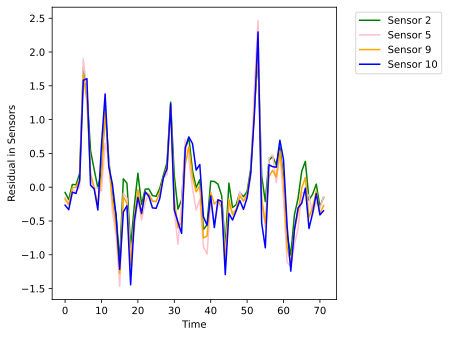

In [ ]:
fig, ax = plt.subplots()
ax.plot(residuals_3[1],color='green',label='Sensor 2')
ax.plot(residuals_3[4],color='pink',label='Sensor 5')
ax.plot(residuals_3[8],color='orange',label='Sensor 9')
ax.plot(residuals_3[9],color='blue',label='Sensor 10')
plt.xlabel('Time')
plt.ylabel('Residual in Sensors')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

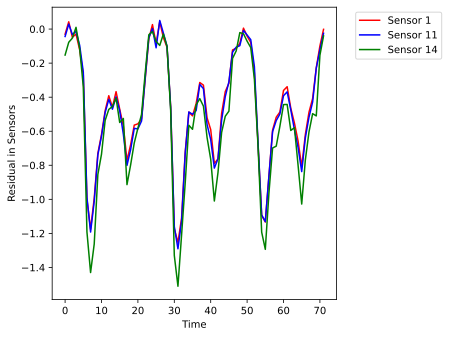

In [ ]:
fig, ax = plt.subplots()

ax.plot(residuals_3[0],color='red',label='Sensor 1')
ax.plot(residuals_3[10],color='blue',label='Sensor 11')
ax.plot(residuals_3[13],color='green',label='Sensor 14')
plt.xlabel('Time')
plt.ylabel('Residual in Sensors')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

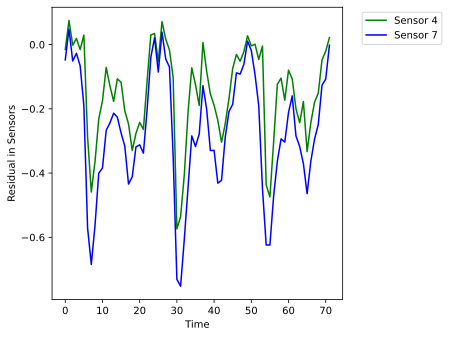

In [ ]:
fig, ax = plt.subplots()
ax.plot(residuals_3[3],color='green',label='Sensor 4')
ax.plot(residuals_3[6],color='blue',label='Sensor 7')
plt.xlabel('Time')
plt.ylabel('Residual in Sensors')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

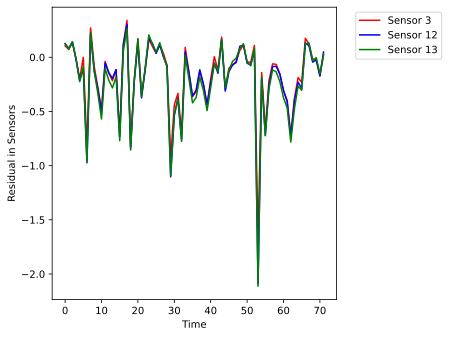

In [ ]:
fig, ax = plt.subplots()

ax.plot(residuals_3[2],color='red',label='Sensor 3')
ax.plot(residuals_3[11],color='blue',label='Sensor 12')
ax.plot(residuals_3[12],color='green',label='Sensor 13')
plt.xlabel('Time')
plt.ylabel('Residual in Sensors')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()